# **Laboratorio 4**

Angélica Ortiz - 202222480 
<br>
María José Amorocho - 202220179

# Importaciones

In [39]:
#importaciones
import numpy as np
from tabulate import tabulate
from pyomo.environ import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Problema 1 - Implementación del Método Simplex Estándar

## Implementación

In [40]:
import time
def simplex_con_iteraciones(A, b, c, imprimir=True, modo='max'):
    """
    Implementa el Método Simplex y retorna los valores finales 
    de todas las variables (originales y de holgura).
    
    Máx  z = c^T x
    s.a. A x <= b
         x >= 0

    Args:
    A :  Matriz de coeficientes de las restricciones (m x n)
    b :  Vector de términos independientes (m,1)
    c :  Vector de coeficientes de la función objetivo (n,)
    imprimir : Si es True, se imprime la tabla y detalles en cada iteración
    modo: si es problema de maximización (max) o minimización (min)

    Returns:
    matriz_simplex : Matriz después de toads las iteraciones
    z_opt : Valor óptimo de la función objetivo
    """
    start = time.time()
    # Establecer numero de restricciones y de variables
    m, n = A.shape
    
    # Si es un problema de minimización, convertirlo a maximización
    if modo == 'min':
        c = -c
    
    # Establecer matriz de identidad para variables de holgura
    I = np.eye(m)
    
    # Construccion de la matriz A con las variables de holgura incluidas
    A_ext = np.hstack([A, I]) #matriz de tamaño m x (n+m)
    
    #Extender el vector c para incluir las variables de holgura
    c_ext = np.concatenate([c, np.zeros(m)])
    
    # Construir la tabla: dimensiones (m+1) x (n+m+1)
    # (m+1) filas > m restricciones + 1 fila de función objetivo
    # (n+m+1) columnas > n+m variables (originales y de holgura) + 1columna para terminos independientes (b)
    matriz_simplex = np.zeros((m+1, n+m+1))
    
    # Llenar las filas de restricciones
    for i in range(m):
        matriz_simplex[i, :-1] = A_ext[i]
        matriz_simplex[i, -1]  = b[i]
    
    # Fila de la función objetivo (utilizando -c para la maximización)
    matriz_simplex[-1, :-1] = -c_ext
    
    # iniciar las iteraciones
    iteracion = 0
    while True:
        if imprimir:
            print(f"Iteración {iteracion}:")
            print(tabulate(matriz_simplex, floatfmt=".3f", tablefmt="grid"))
            print("-" * 50)
        
        # 1. Buscar la columna pivote (más negativa en la fila de la función objetivo)
        fila_objetivo = matriz_simplex[-1, :-1]
        col_in = np.argmin(fila_objetivo)
        valor_min = fila_objetivo[col_in]
        
        # si todos los valores en la fila de la función objetivo son positivos se ha encontrado el optimo
        if valor_min >= 0:
            if imprimir:
                print("Óptimo alcanzado.")
            break  # Solución óptima alcanzada
        
        # 2. Seleccionar la fila pivote usando el cociente mínimo
        columna_pivote = matriz_simplex[:-1, col_in]
        b_column = matriz_simplex[:-1, -1]
        
        # calcular las divisiones o razones
        razones = []
        for i in range(m):
            if columna_pivote[i] > 1e-15: # manejar divisiones por cero o muy pequeñas
                razones.append(b_column[i] / columna_pivote[i])
            else:
                razones.append(np.inf)
                
         # La fila con la razón mínima es la que sale de la base
        fila_out = np.argmin(razones)
        if razones[fila_out] == np.inf:
            # Problema no acotado > cuando todas las razones calculadas dan infinito
            raise ValueError("El problema es no acotado.")
        
        if imprimir:
            print(f"Columna que entra: {col_in+1}")
            print(f"Fila que sale: {fila_out+1}")
            print(f"Valor pivote: {matriz_simplex[fila_out, col_in]}")
        
        # 3. normalizar la fila pivote para que el elemento pivote sea 1
        pivote = matriz_simplex[fila_out, col_in]
        matriz_simplex[fila_out, :] /= pivote
        
        # Copnvetir en ceros en el resto de la columna pivote
        for i in range(m+1):
            if i != fila_out:
                factor = matriz_simplex[i, col_in]
                matriz_simplex[i, :] -= factor * matriz_simplex[fila_out, :]
        
        iteracion += 1
        
    # Valor óptimo obtenido en la tabla
    z_opt = matriz_simplex[-1, -1]
    # Para problemas de minimización, revertir el signo del óptimo
    if modo == 'min':
        z_opt = -z_opt
    
    end = time.time()
    print(f">>Tiempo total de resolución: {end - start:.4f} segundos")
    return matriz_simplex, z_opt

def extraer_resultados_simplex(matriz_simplex, A):
    """
    Extrae los resultados de las variables de una matriz final

    Args:
        matriz_simplex: matriz resultante que dontiene el valor objetivo
        A: Matriz de restricciones

    Returns:
        resultado: diccionario con los valores de las variables
    """
    m, n = A.shape
    
    # Extraer la solución óptima > se revisan todas las columnas (originales + holgura)
    x_opt = np.zeros(n + m)
    for col_index in range(n + m):
        # Extraer la columna correspondiente a las filas de restricciones
        col = matriz_simplex[:m, col_index]
        # verificar si es columna canónica (un 1 y el resto 0's)
        if np.count_nonzero(col) == 1 and np.isclose(np.max(col), 1.0):
            row_index = np.argmax(col)
            x_opt[col_index] = matriz_simplex[row_index, -1]
    
    # diccionario para diferenciar variables originales y de holgura
    resultados = {}
    for i in range(n):
        resultados[f'x{i+1}'] = x_opt[i]
    for i in range(m):
        resultados[f'x{n+i+1}'] = x_opt[n + i]
    
    return resultados

## Primera ejecución

La próxima ejecución muestra el paso a paso hecho por el algortimo hasta llegar al valor óptimo, los valores resultantes de las variables

In [41]:
# Ejemplo:
# Máx z = 3x1 + 2x2 + 5x3
# Restricciones
#   x1  +  x2  +  x3 <= 100
#   2x1 +  x2  +  x3 <= 150
#   x1  +  4x2 + 2x3 <= 80
# x1, x2, x3 >= 0

A = np.array([
    [1, 1, 1],
    [2, 1, 1],
    [1, 4, 2]
], dtype=float)

b = np.array([100, 150, 80], dtype=float)
c = np.array([3, 2, 5], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=True, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, A)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

Iteración 0:
+--------+--------+--------+--------+--------+--------+---------+
|  1.000 |  1.000 |  1.000 |  1.000 |  0.000 |  0.000 | 100.000 |
+--------+--------+--------+--------+--------+--------+---------+
|  2.000 |  1.000 |  1.000 |  0.000 |  1.000 |  0.000 | 150.000 |
+--------+--------+--------+--------+--------+--------+---------+
|  1.000 |  4.000 |  2.000 |  0.000 |  0.000 |  1.000 |  80.000 |
+--------+--------+--------+--------+--------+--------+---------+
| -3.000 | -2.000 | -5.000 | -0.000 | -0.000 | -0.000 |   0.000 |
+--------+--------+--------+--------+--------+--------+---------+
--------------------------------------------------
Columna que entra: 3
Fila que sale: 3
Valor pivote: 2.0
Iteración 1:
+--------+--------+-------+-------+-------+--------+---------+
|  0.500 | -1.000 | 0.000 | 1.000 | 0.000 | -0.500 |  60.000 |
+--------+--------+-------+-------+-------+--------+---------+
|  1.500 | -1.000 | 0.000 | 0.000 | 1.000 | -0.500 | 110.000 |
+--------+--------+--

A continuación se muestra una representación geométrica del problema

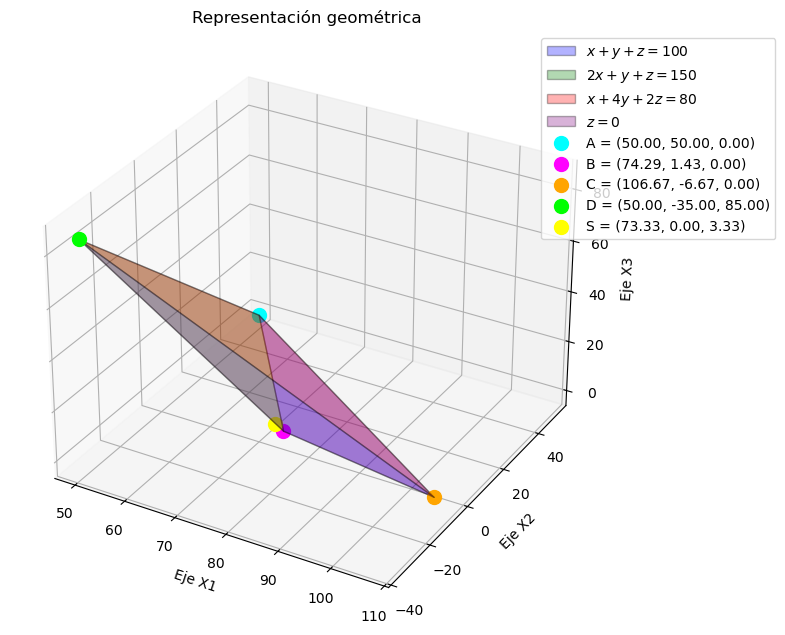

In [42]:
# Puntos del poliedro
A_p = np.array([50, 50, 0])
B = np.array([74.29, 1.43, 0])
C = np.array([106.67, -6.67, 0])
D = np.array([50, -35, 85])
S = np.array([73.333, 0, 3.333])  # Punto optimo
vertices = np.array([A_p, B, C, D])

# Definir caras figura - espacio de solución
caras = [
    [vertices[0], vertices[1], vertices[2]],  # ABC
    [vertices[0], vertices[1], vertices[3]],  # ABD
    [vertices[0], vertices[2], vertices[3]],  # ACD
    [vertices[1], vertices[2], vertices[3]]   # BCD
]

# Ecuaciones de los planos/restricciones
ecuaciones_planos = [
    r"$x + y + z = 100$",
    r"$2x + y + z = 150$",
    r"$x + 4y + 2z = 80$",
    r"$z = 0$"
]

# Colores
colores_caras = ['blue', 'green', 'red', 'purple']
colores_puntos = ['cyan', 'magenta', 'orange', 'lime', 'yellow']  # Para A, B, C, D, S

# Crear figura 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Dibujar caras con sus ecuaciones
for i, (cara, color, ecuacion) in enumerate(zip(caras, colores_caras, ecuaciones_planos)):
    triangulo = Poly3DCollection([cara], alpha=0.3, linewidths=1, edgecolor='k', facecolor=color)
    triangulo.set_label(ecuacion)  # Leyenda: ecuación del plano
    ax.add_collection3d(triangulo)
    
puntos = [A_p, B, C, D, S]
nombres = ['A', 'B', 'C', 'D', 'S']
for punto, nombre, color in zip(puntos, nombres, colores_puntos):
    ax.scatter(*punto, color=color, s=100, label=f"{nombre} = ({punto[0]:.2f}, {punto[1]:.2f}, {punto[2]:.2f})")

# ejes y leyenda
ax.set_xlabel('Eje X1')
ax.set_ylabel('Eje X2')
ax.set_zlabel('Eje X3')
ax.set_title('Representación geométrica')

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()

## Segunda ejecución

En esta ejecución, los coeficientes de la función objetivo son modificados con el fin de, posteriormente, hacer un análisis breve de sensibilidad

In [43]:
# incrementando x2 en 1
c = np.array([3, 3, 5], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, A)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

>>Tiempo total de resolución: 0.0001 segundos

Valor final de las variables:
> x1: 73.333
> x2: 0.0
> x3: 3.333
> x4: 23.333
> x5: 0.0
> x6: 0.0
Valor óptimo de la función objetivo: 236.667


Como se puede ver, incrementar en una unidad el coeficiente de $x_2$ no cambia la base de la solución optima ni el valor óptimo. Todos los valores siguen siendo iguales, pues de la tabla resultante después de ejecutar Simplex puede saberse que lo máximo que tendría permitido aumentar $x_2$ es en 7.667 unidades (aproximadamente) para que no cambiara el resultado óptimo. Así mismo, esta variable podría reducirse infinitamente sin afectar el resultado. 

In [44]:
# incrementando x2 en 8
c = np.array([3, 11, 5], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, A)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

>>Tiempo total de resolución: 0.0001 segundos

Valor final de las variables:
> x1: 74.286
> x2: 1.429
> x3: 0.0
> x4: 24.286
> x5: 0.0
> x6: 0.0
Valor óptimo de la función objetivo: 238.571


Incrementando el coeficiente de $x_2$ en 8 unidades (más de lo que tendría permitido), se ve que la base de la solución óptima cambia, así como el valor de la función objetivo.

In [45]:
# disminuyendo x2 en 8
c = np.array([3, -11, 5], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, A)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

>>Tiempo total de resolución: 0.0002 segundos

Valor final de las variables:
> x1: 73.333
> x2: 0.0
> x3: 3.333
> x4: 23.333
> x5: 0.0
> x6: 0.0
Valor óptimo de la función objetivo: 236.667


De manera similar, se hace el ejercicio de decrementar el valor del coeficiente de $x_2$ en 8 unidades y se observa que la base de la solución optima y el valor óptimo son los mismos que en el problema original. Como $x_2$ es una variable no básica, el valor de su coeficiente va a poder decrementar infinitamente sin impactar la solución original. 

In [46]:
# incementando x1 en 1
c = np.array([4, 2, 5], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, A)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

>>Tiempo total de resolución: 0.0001 segundos

Valor final de las variables:
> x1: 73.333
> x2: 0.0
> x3: 3.333
> x4: 23.333
> x5: 0.0
> x6: 0.0
Valor óptimo de la función objetivo: 310.0


Como $x_1$ es una variable básica, para calcular cuánto es lo máximo que podría aumentar o disminuir su coeficiente sin cambiar la base óptima de la solución, el cálculo es un poco más largo, por lo que no se incluirá en este problema. No obstante, se puede ver que incrementando este en una unidad, la base óptima del problema permanece igual. Lo único que se ve impactado es el valor de la función objetivo (lo que tiene coherencia pues se está modificando el coeficiente de una vaiable que determina directamente este valor).

## Tercera ejecución

En esta ejecución los términos independientes que afectan la solución son modificados

In [47]:
c = np.array([3, 2, 5], dtype=float) # restaurar coeficientes

# Incrementando primer termino independiente en 1
b = np.array([101, 150, 80], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

>>Tiempo total de resolución: 0.0001 segundos
Valor óptimo de la función objetivo: 236.667


In [48]:
# Incrementando segundo termino independiente en 1
b = np.array([100, 151, 80], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

>>Tiempo total de resolución: 0.0001 segundos
Valor óptimo de la función objetivo: 237.0


In [49]:
# Incrementando tercer termino independiente en 1
b = np.array([100, 150, 81], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

>>Tiempo total de resolución: 0.0001 segundos
Valor óptimo de la función objetivo: 239.0


Al cambiar diferentes términos independientes (límites de las restricciones) puede evidenciarse que, al cambiar en una unidad estos, no se obtiene el mismo resultado. Por ejemplo, al incrementar en una unidad el término independiente de la primera restricción, no hubo cambio en el valor optimo. Al incrementar en una unidad el término independiente de la segunda restricción, el cambio en la función objetivo fue de aproximadamente 0.4 unidades y al hacer la misma modificación al término independiente de la tercera restricción, el cambio fue de aproximadamente 2.3 unidades. Lo anterior confirma que el mismo cambio en diferentes términos no genera el mismo resultado ni en las mismas proporciones.

# Problema 2 - Implementación del Método Simplex Dual Phase

In [60]:
import time

def convertir_a_forma_estandar(restricciones, funcion_objetivo):
    b = []

    n_originales = len(restricciones[0][0])
    nombres_x = [f'x{i+1}' for i in range(n_originales)]
    nombres_R = []
    basicas = []

    filas_info = []

    idx_x = n_originales  # índice para x de holgura o exceso
    idx_R = 1              # índice para R artificiales

    # Función objetivo (con ceros para las nuevas variables)
    c = [funcion_objetivo.get(f'x{i+1}', 0) for i in range(n_originales)]

    for coef, signo, ti in restricciones:
        fila = coef[:]
        var_extra = []
        fila_vals = fila[:]

        if signo == '<=':
            nombre_x = f'x{idx_x + 1}'
            nombres_x.append(nombre_x)
            var_extra.append((nombre_x, 1))
            basicas.append(nombre_x)
            idx_x += 1

        elif signo == '>=':
            # Exceso
            nombre_x = f'x{idx_x + 1}'
            nombres_x.append(nombre_x)
            var_extra.append((nombre_x, -1))
            idx_x += 1

            # Artificial
            nombre_R = f'R{idx_R}'
            nombres_R.append(nombre_R)
            var_extra.append((nombre_R, 1))
            basicas.append(nombre_R)
            idx_R += 1

        elif signo == '=':
            nombre_R = f'R{idx_R}'
            nombres_R.append(nombre_R)
            var_extra.append((nombre_R, 1))
            basicas.append(nombre_R)
            idx_R += 1

        filas_info.append((fila_vals, var_extra, ti))
        
    nombres_vars = nombres_x + nombres_R
    total_vars = len(nombres_vars)

    # Crear la matriz de restricciones
    A = []
    for fila_base, extra_vars, ti in filas_info:
        fila_expandida = [0] * total_vars
        for i, val in enumerate(fila_base):
            fila_expandida[i] = val
        for nombre, valor in extra_vars:
            idx = nombres_vars.index(nombre)
            fila_expandida[idx] = valor
        A.append(fila_expandida)
        b.append(ti)

    # Generar la función objetivo
    c.extend([0] * (total_vars - len(c)+1))  # Agregar ceros de las nuevas variables

    A = np.array(A)
    b = np.array(b)

    return A, b, nombres_vars, basicas, np.array(c)

def dual_simplex(A, b, nombres_vars, basicas, funcion_objetivo, modo, imprimir=True):
    start = time.time()
    def construir_tabla_fase1(A, b, c_aux, artificiales, nombres_vars, basicas, modo):
    # función auxiliar: w = a1 + a2
        if modo == 'min':
            c_aux = -c_aux
        m, n = A.shape
        tabla = np.zeros((m + 1, n + 1))
        for i in range(m):
            tabla[i, :-1] = A[i]
            tabla[i, -1] = b[i]
        tabla[-1, :] = c_aux
        if artificiales==1:
            M = 1
            tabla[-1, :] = -c_aux
            for i, var in enumerate(basicas):
                if var.startswith('R'):
                    tabla[-1, :] += M * tabla[i, :]     
        print("Tabla inicial Fase I:")
        print(tabulate(tabla, headers=nombres_vars + ['b'], floatfmt=".3f", tablefmt="grid"))

        return tabla, nombres_vars, basicas,m,n


    def simplex_desde_tabla(tabla, nombres_vars, basicas,fase, imprimir=True):
        m, n = tabla.shape
        m -= 1  # número de restricciones
        n -= 1  # número de variables (sin b)

        iteracion = 0
        while True:
            if imprimir:
                print(f"\nIteración {iteracion}:")
                encabezados = nombres_vars + ['b']
                tabla_legible = [[basicas[i]] + list(tabla[i]) for i in range(m)] + [['Z'] + list(tabla[-1])]
                print(tabulate(tabla_legible, headers=["Base"] + encabezados, floatfmt=".3f", tablefmt="grid"))

            z = tabla[-1, :-1]
            col_in = np.argmax(z)
            if z[col_in] <= 0:
                if fase==1:
                    print("Óptimo alcanzado en fase 1.")
                if fase==2:
                    print("Óptimo alcanzado en fase 2.")
                break

            columna = tabla[:-1, col_in]
            b = tabla[:-1, -1]
            razones = [b[i] / columna[i] if columna[i] > 1e-8 else np.inf for i in range(m)]
            fila_out = np.argmin(razones)

            if razones[fila_out] == np.inf:
                print("No se puede resolver.")
                return None

            # Mostrar variable que entra y sale
            variable_entra = nombres_vars[col_in]
            variable_sale = basicas[fila_out]
            print(f"Entra: {variable_entra} Sale: {variable_sale}")

            # Actualizar base
            basicas[fila_out] = variable_entra

            # Pivote
            pivote = tabla[fila_out, col_in]
            tabla[fila_out, :] /= pivote
            for i in range(m + 1):
                if i != fila_out:
                    tabla[i, :] -= tabla[i, col_in] * tabla[fila_out, :]

            iteracion += 1

        return tabla,encabezados,basicas

    artificiales = 1 if any('R' in var for var in nombres_vars) else 0
    if artificiales:
        #fase1
        c_aux = np.array([0 if 'R' not in var else -1 for var in nombres_vars] + [0])
        tabla_fase1, nombres_vars, basicas, m, n = construir_tabla_fase1(A, b, c_aux, artificiales, nombres_vars, basicas, modo)
        tabla_final, encabezados, basicas = simplex_desde_tabla(tabla_fase1, nombres_vars, basicas, 1, imprimir)

        cols_a_eliminar = [i for i, var in enumerate(nombres_vars) if 'R' in var]
        nombres_vars2 = [var for i, var in enumerate(nombres_vars) if i not in cols_a_eliminar]
        tabla_final = [[float(valor) for valor in fila] for fila in tabla_final]
        tabla_final = [[valor for i, valor in enumerate(fila) if i not in cols_a_eliminar] for fila in tabla_final]

        m = len(basicas)
        n = len(nombres_vars2)
        fila_z = np.zeros(n + 1)

        for i in range(m):
            var = basicas[i]
            if var in funcion_objetivo:
                coef = funcion_objetivo[var]
                fila_z += coef * np.array(tabla_final[i])

        for j, var in enumerate(nombres_vars2):
            if var in funcion_objetivo and var not in basicas:
                fila_z[j] -= funcion_objetivo[var]

        for i in range(m):
            var = basicas[i]
            fila_z[n] = fila_z[n]
            if var in funcion_objetivo:
                fila_z[nombres_vars2.index(var)] = 0

        tabla_final[-1] = fila_z
        tabla_final = np.array(tabla_final, dtype=float)
        #fase 2

        tabla_final2, encabezados2, basicas2 = simplex_desde_tabla(tabla_final, nombres_vars2, basicas, 2, imprimir)
        valor_optimo = tabla_final2[-1, -1]
        if(modo=='max'):
            print("Valor óptimo= " + str(-valor_optimo))
        else:
            print("Valor óptimo= " + str(valor_optimo))

    else:
        #fase2
        m, n = A.shape
        tabla_fase1, nombres_vars, basicas, m, n = construir_tabla_fase1(A, b, funcion_objetivo, artificiales, nombres_vars, basicas, modo)
        tabla_fase1 = np.array(tabla_fase1, dtype=float)
        tabla_final, encabezados, basicas = simplex_desde_tabla(tabla_fase1, nombres_vars, basicas, 1, imprimir)
        valor_optimo = tabla_final[-1, -1]
        if(modo=='max'):
            print("Valor óptimo= " + str(-valor_optimo))
        else:
            print("Valor óptimo= " + str(valor_optimo))
    end = time.time()
    print(f"\nTiempo total de resolución: {end - start:.4f} segundos")
    

In [61]:
restricciones = [
    ([2, 1, -1], '=', 10),
    ([1, -3, 2], '>=', 5),
    ([1, 1, 1], '<=', 15)
]
funcion_objetivo = {'x1': 5, 'x2': -4, 'x3': 3}
A, b, nombres_vars, basicas,fun = convertir_a_forma_estandar(restricciones,funcion_objetivo)
dual_simplex(A, b, nombres_vars, basicas, funcion_objetivo,modo='min')

Tabla inicial Fase I:
+-------+--------+--------+--------+-------+-------+-------+--------+
|    x1 |     x2 |     x3 |     x4 |    x5 |    R1 |    R2 |      b |
+=======+========+========+========+=======+=======+=======+========+
| 2.000 |  1.000 | -1.000 |  0.000 | 0.000 | 1.000 | 0.000 | 10.000 |
+-------+--------+--------+--------+-------+-------+-------+--------+
| 1.000 | -3.000 |  2.000 | -1.000 | 0.000 | 0.000 | 1.000 |  5.000 |
+-------+--------+--------+--------+-------+-------+-------+--------+
| 1.000 |  1.000 |  1.000 |  0.000 | 1.000 | 0.000 | 0.000 | 15.000 |
+-------+--------+--------+--------+-------+-------+-------+--------+
| 3.000 | -2.000 |  1.000 | -1.000 | 0.000 | 0.000 | 0.000 | 15.000 |
+-------+--------+--------+--------+-------+-------+-------+--------+

Iteración 0:
+--------+-------+--------+--------+--------+-------+-------+-------+--------+
| Base   |    x1 |     x2 |     x3 |     x4 |    x5 |    R1 |    R2 |      b |
+========+=======+========+========+

# Problema 3 - Comparación de Rendimiento con GLPK/Pyomo

In [62]:
from pyomo.environ import *
import time
model = ConcreteModel()

# Conjuntos de variables y restricciones
model.I = RangeSet(1, 10) 
model.J = RangeSet(1, 8) 

# Coeficientes de la función objetivo
c = [5, 8, 3, 7, 6, 9, 4, 10, 2, 11]

# Coeficientes de las restricciones
A = {
    1: [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    2: [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    3: [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    4: [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    5: [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    6: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    7: [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    8: [1, 0, 1, 2, 1, 0, 1, 2, 1, 1],
}

# Términos independientes b
b = [50, 60, 55, 40, 45, 70, 65, 50]

# Variables de decisión
model.x = Var(model.I, domain=NonNegativeReals)

# Función objetivo
model.obj = Objective(expr=sum(c[i-1]*model.x[i] for i in model.I), sense=maximize)

# Restricciones
def constraint_rule(model, j):
    return sum(A[j][i-1]*model.x[i] for i in model.I) <= b[j-1]
model.constraints = Constraint(model.J, rule=constraint_rule)

solver = SolverFactory('glpk')

#tiempo
start = time.time()
results = solver.solve(model, tee=True)
end = time.time()

print("\n*** Resultados ***")
print(f"Solución óptima encontrada.")
print(f"Valor óptimo Z = {model.obj():.2f}")
for i in model.I:
    val = model.x[i].value
    if val > 1e-6:
        print(f"x{i} = {val:.2f}")
print(f"\nTiempo total de resolución: {end - start:.4f} segundos")

# iteraciones no se imprime
if hasattr(results.solver, 'iterations'):
    print(f"Iteraciones: {results.solver.iterations}")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/qy/9629zpq93xlgwp2b4f9b22280000gn/T/tmpmn3nifh8.glpk.raw
 --wglp /var/folders/qy/9629zpq93xlgwp2b4f9b22280000gn/T/tmp61xbkqsx.glpk.glp
 --cpxlp /var/folders/qy/9629zpq93xlgwp2b4f9b22280000gn/T/tmps14e16i6.pyomo.lp
Reading problem data from '/var/folders/qy/9629zpq93xlgwp2b4f9b22280000gn/T/tmps14e16i6.pyomo.lp'...
8 rows, 10 columns, 65 non-zeros
118 lines were read
Writing problem data to '/var/folders/qy/9629zpq93xlgwp2b4f9b22280000gn/T/tmp61xbkqsx.glpk.glp'...
104 lines were written
GLPK Simplex Optimizer 5.0
8 rows, 10 columns, 65 non-zeros
Preprocessing...
8 rows, 10 columns, 65 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  3.000e+00  ratio =  3.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (10)
*     4: obj =   3.756250000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTI

In [63]:
r = np.array([
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1, ],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1,],
])
b1 = np.array([50, 60, 55, 40, 45, 70, 65, 50])
c1 = np.array([5, 8, 3, 7, 6, 9, 4, 10, 2, 11])
matriz_simplex, valor_objetivo = simplex_con_iteraciones(r, b1, c1, imprimir=True, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, r)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

Iteración 0:
+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  1.000 |  2.000 |  1.000 |  1.000 |  0.000 |  0.000 |  3.000 |   1.000 |  2.000 |   1.000 |  1.000 |  0.000 |  0.000 |  0.000 |  0.000 |  0.000 |  0.000 |  0.000 | 50.000 |
+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  2.000 |  1.000 |  0.000 |  2.000 |  1.000 |  1.000 |  0.000 |   3.000 |  1.000 |   2.000 |  0.000 |  1.000 |  0.000 |  0.000 |  0.000 |  0.000 |  0.000 |  0.000 | 60.000 |
+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  1.000 |  1.000 |  2.000 |  0.000 |  2.000 |  1.000 |  1.000 |   0.000 |  3.000 |   1.000 |  0.000 |  0.000 | 

In [64]:
# Restricciones
restricciones = [
    ([1, 2, 1, 1, 0, 0, 3, 1, 2, 1], '<=', 50),
    ([2, 1, 0, 2, 1, 1, 0, 3, 1, 2], '<=', 60),
    ([1, 1, 2, 0, 2, 1, 1, 0, 3, 1], '<=', 55),
    ([0, 2, 1, 1, 1, 0, 2, 1, 1, 1], '<=', 40),
    ([2, 0, 1, 1, 1, 2, 1, 1, 0, 2], '<=', 45),
    ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], '<=', 70),
    ([0, 1, 2, 1, 0, 1, 2, 1, 1, 0], '<=', 65),
    ([1, 0, 1, 2, 1, 0, 1, 2, 1, 1], '<=', 50)
]
funcion_objetivo = {
    'x1': 5, 'x2': 8, 'x3': 3, 'x4': 7, 'x5': 6,
    'x6': 9, 'x7': 4, 'x8': 10, 'x9': 2, 'x10': 11
}
# Llamamos a la función
A, b, nombres_vars, basicas,funcion_objetivo2 = convertir_a_forma_estandar(restricciones,funcion_objetivo)
A=np.array(A)
b=np.array(b)
dual_simplex(A, b, nombres_vars, basicas, funcion_objetivo2, modo='max')

Tabla inicial Fase I:
+-------+-------+-------+-------+-------+-------+-------+--------+-------+--------+-------+-------+-------+-------+-------+-------+-------+-------+--------+
|    x1 |    x2 |    x3 |    x4 |    x5 |    x6 |    x7 |     x8 |    x9 |    x10 |   x11 |   x12 |   x13 |   x14 |   x15 |   x16 |   x17 |   x18 |      b |
+=======+=======+=======+=======+=======+=======+=======+========+=======+========+=======+=======+=======+=======+=======+=======+=======+=======+========+
| 1.000 | 2.000 | 1.000 | 1.000 | 0.000 | 0.000 | 3.000 |  1.000 | 2.000 |  1.000 | 1.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 50.000 |
+-------+-------+-------+-------+-------+-------+-------+--------+-------+--------+-------+-------+-------+-------+-------+-------+-------+-------+--------+
| 2.000 | 1.000 | 0.000 | 2.000 | 1.000 | 1.000 | 0.000 |  3.000 | 1.000 |  2.000 | 0.000 | 1.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 60.000 |
+-------+-------+-------+-------+---

# Problema 4 - Análisis de Sensibilidad en Programación Lineal

## Análisis de Sensibilidad para Coeficientes de la Función Objetivo

### Implementación

In [65]:
def analisis_sensibilidad_coeficientes(matriz_simplex, c, n, m, modo='max', imprimir=True):
    """
    Realiza el análisis de sensibilidad de los coeficientes de la función objetivo
    
    Args:
    matriz_simplex : matriz final del Método Simplex > de dimensión (m+1) x (n+m+1)
    c : Coeficientes originales de la función objetivo (tamaño n).
    n : numero de variables originales (excluyendo holgura).
    m : numero de restricciones.
    modo : 'max'si el problema es de maximización,'min'si es de minización
    imprimir : Si True, imprime resultados

    Return:
    dict_sensibilidad : diccionario con rango de variacion de las variables (basicas y no basicas)
    """
    # Identificar variables básicas y no básicas a partir de la submatriz de restricciones
    submatriz_restricciones = matriz_simplex[:m, :n+m]  # m filas, (n+m) columnas (sin la columna RHS)
    
    cols_basicas = []
    for j in range(n+m):
        col_j = submatriz_restricciones[:, j]
        # Chequeo vector identidad en la submatriz
        if np.count_nonzero(col_j) == 1:
            fila_1 = np.where(abs(col_j - 1) < 1e-12)[0]
            if len(fila_1) == 1:
                i_fila = fila_1[0]
                # Verificar ceros en el resto
                if all(abs(x) < 1e-12 for idx, x in enumerate(col_j) if idx != i_fila):
                    cols_basicas.append(j)

    todas_las_cols = list(range(n+m))
    cols_no_basicas = [j for j in todas_las_cols if j not in cols_basicas]

    
    # Extender c con ceros para las variables de holgura
    c_extended = np.concatenate([c, np.zeros(m)]) #c_extended[j] es el "coeficiente actual" c_j^actual de la columna j
   
    # Obtener costos reducidos (r_j) desde la última fila de la tabla final 
    fila_objetivo = matriz_simplex[-1, :n+m]  # fila_objetivo son las primeras (n+m) columnas de la última fila

    reduced_costs = fila_objetivo
    
    if modo == 'min':
        reduced_costs = -reduced_costs
    
    # Calcular los rangos de estabilidad para cada variable
    dict_sensibilidad = {'basicas': {}, 'no_basicas': {}}

    # Para cada variable NO básica x_j
    for j in cols_no_basicas:
        var_name = f"x{j+1}"
        r_j = reduced_costs[j]
        c_j_actual = c_extended[j]
      
        if r_j > 0:
            # si r_j > 0 c_j puede disminuir hasta que r_j se vuelva 0
            # intevalos -> -infinito,  c_j_actual - r_j
            c_j_max = c_j_actual + r_j
            c_j_min = -float('inf')
            
        else:  # r_j < 0
            # c_j puede aumentar hasta que r_j se vuelva 0
            #intervalos ->  c_j_actual - r_j, infinito
            c_j_min = float('inf')
            c_j_max = c_j_actual - r_j
            

        dict_sensibilidad['no_basicas'][var_name] = {
            'c_j_actual': c_j_actual,
            'c_j_min': c_j_min,
            'c_j_max': c_j_max,
            'r_j': r_j,
        }
    
     # Para cada variable BÁSICA x_i
    for j in cols_basicas:
        var_name = f"x{j+1}"
        c_j_actual = c_extended[j]
        col_j = submatriz_restricciones[:, j]

        # Buscar la fila i donde col_j tiene 1
        fila_i_arr = np.where(abs(col_j - 1) < 1e-12)[0]
        if len(fila_i_arr) != 1:
            # Caso sin solución
            dict_sensibilidad['basicas'][var_name] = {
                'c_j_actual': c_j_actual,
                'c_j_min': None,
                'c_j_max': None,
            }
            continue

        i = fila_i_arr[0]
        # Coeficientes de la fila i en las columnas [0..n+m)
        fila_i_coeffs = matriz_simplex[i, :n+m]
        valores_inc = []  # candidatos para delta c_i^+
        valores_dec = []  # candidatos para delta c_i^-

        for k in cols_no_basicas:
            a_ik = fila_i_coeffs[k]
            r_k = reduced_costs[k]
            
            if abs(a_ik) < 1e-12:
                continue

            if a_ik < 0:
                val_posible = -r_k / a_ik
                if val_posible >= 0:
                    valores_inc.append(val_posible)
            else:  # a_ik > 0
                val_posible = r_k / a_ik
                if val_posible >= 0:
                    valores_dec.append(val_posible)

        # Tomar mínimos
        if len(valores_inc) > 0:
            delta_c_i_plus = min(valores_inc)
        else:
            delta_c_i_plus = float('inf')

        if len(valores_dec) > 0:
            delta_c_i_minus = min(valores_dec)
        else:
            delta_c_i_minus = float('inf')

        # Rango para c_i:
        c_j_min = c_j_actual - delta_c_i_minus
        c_j_max = c_j_actual + delta_c_i_plus

        dict_sensibilidad['basicas'][var_name] = {
            'c_j_actual': c_j_actual,
            'c_j_min': c_j_min,
            'c_j_max': c_j_max,
            'incremento_permitido': delta_c_i_plus,
            'decremento_permitido': delta_c_i_minus
        }

    # Imprimir resultados
    
    if imprimir:
        headers = ['variable', 'intervalo', 'Permisible reducir', 'actual', 'Permisible aumentar']
        print("\n=== Análisis de Sensibilidad de Coeficientes ===")
           
        tabla = []
        for var_no_basica, info in dict_sensibilidad["no_basicas"].items():
            fila = []
            intervalo = f"{info['c_j_min']:.2f} < {var_no_basica} < {info['c_j_max']:.2f}"
            fila.append(var_no_basica)
            fila.append(intervalo)
            fila.append(info['c_j_min'])
            fila.append(info['c_j_actual'])
            fila.append(info['r_j'])
            tabla.append(fila)
            
        print('Variables NO básicas \n' + tabulate(tabla, headers=headers, tablefmt='grid'))
            
        print("\nVariables BÁSICAS:")
        tabla2 = []
        for var_name, info in dict_sensibilidad['basicas'].items():
            fila = []
            fila.append(var_name)
            intervalo = f"{info['c_j_min']:.2f} < {var_name} < {info['c_j_max']:.2f}"
            fila.append(intervalo)
            fila.append(info['decremento_permitido'])
            fila.append(info['c_j_actual'])
            fila.append(info['incremento_permitido'])
            tabla2.append(fila)
            
        print(tabulate(tabla2, headers=headers, tablefmt='grid'))
    return dict_sensibilidad


### Ejecución

In [66]:
# Ejemplo:
# Máx z = 4x1 + 3x2
# Restricciones
#   x1  +  2x2  <= 8
#  3x1 +  2x2  <= 12
# x1, x2>= 0

A = np.array([
    [1, 2],
    [3, 2],
], dtype=float)

b = np.array([8, 12], dtype=float)
c = np.array([4, 3], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, A)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

# Dimensiones de A
m, n = A.shape
sensibilidad = analisis_sensibilidad_coeficientes(matriz_simplex, c, n, m, modo='max', imprimir=True)


>>Tiempo total de resolución: 0.0002 segundos

Valor final de las variables:
> x1: 2.0
> x2: 3.0
> x3: 0.0
> x4: 0.0
Valor óptimo de la función objetivo: 17.0

=== Análisis de Sensibilidad de Coeficientes ===
Variables NO básicas 
+------------+------------------+----------------------+----------+-----------------------+
| variable   | intervalo        |   Permisible reducir |   actual |   Permisible aumentar |
+============+==================+======================+==========+=======================+
| x3         | -inf < x3 < 0.25 |                 -inf |        0 |                  0.25 |
+------------+------------------+----------------------+----------+-----------------------+
| x4         | -inf < x4 < 1.25 |                 -inf |        0 |                  1.25 |
+------------+------------------+----------------------+----------+-----------------------+

Variables BÁSICAS:
+------------+------------------+----------------------+----------+-----------------------+
| variable   

De los resultados obtenidos puede decirse que, en cuanto a los rangos de factibilidad, la base de la solución óptima no cambiará a menos de que $x_1$ tome un valor mayor o igual a 4.5 o menor o igual a -1.5. De forma similar, a menos que $x_2$ adquiera un valor mayor o igual a 8, o menor o igual a -2.67, la base óptima del problema no se verá afectada. Que no cambie la base óptima del problema significa que las variables básicas y no básicas sean las mismas que en el problema original (aunque el valor objetivo pueda cambiar). Esto es lo que significa tener rangos de estabilidad. En el caso propuesto, mantener la misma base óptima significa que $x_1$ y $x_2$ sigan siendo las variables básicas, aunque sus coeficientes se modifiquen (al igual que el valor óptimo de la función objetivo). 

En este caso, si solo se pudiese modificar el coeficiente de algunas de las dos variables, para maximizar el valor de la función objetivo sin que la solución óptima cambie, lo más ideal sería aumentar lo máximo permisible aquella variable con una cota superior más alta; en este caso, sería $x_2$, pues su cota superior (que es 8) es mayor a la cota superior de la variable $x_1$ (que es 4.5).

## Análisis de Sensibilidad para Términos Independientes

### Implementación

In [67]:
def analisis_sensibilidad_independientes(matriz_simplex, A, b, c, modo='max', imprimir=True):
    """
    Análisis de sensibilidad para términos independientes y shadow prices.

    Args:
    matriz_simplex : Matriz final después de Simplex > dimensiones (m+1, n+m+1)
    A : matriz original de restricciones.
    b : Vector de términos independientes originales.
    c : Vector de coeficientes de la función objetivo.
    modo : 'max' si el problema es de maximización,'min' si el problema es de minimización
    imprimir : Si True, imprime resultados

    Returns:
    dict_sens : diccionario de sensilidad con shadow_prices y rangos_b (rangos en los que se puede mover el coeficiente, 
    su mínimo y su maximo)
    """
    m, n = A.shape

    # Construir A_ext = [A | I_m]
    A_ext = np.hstack([A, np.eye(m)])

    # Identificar columnas básicas en la submatriz de restricciones
    subR = matriz_simplex[:m, :n+m]
    cols_basicas = []
    for j in range(n+m):
        col = subR[:, j]
        if np.count_nonzero(col)==1:
            fila = np.where(abs(col-1)<1e-12)[0]
            if len(fila)==1 and all(abs(col[k])<1e-12 for k in range(m) if k!=fila[0]):
                cols_basicas.append(j)

    # Base B y su inversa
    B = A_ext[:, cols_basicas]
    #print(f'Base B: {B}')
    
    B_inv = np.linalg.inv(B)
    #print(f'B_inv: {B_inv}')

    # Shadow prices: y* = c_B^T B^{-1}
    c_ext = np.concatenate([c, np.zeros(m)])
    c_B   = c_ext[cols_basicas]
    #print(f'c_B: {c_B}')
    
    y_star = c_B @ B_inv
    #print(f'y_star: {y_star}')

    # si es minimización > multiplicar por -1
    if modo=='min':
        y_star = -y_star

    # Cálculo de rangos para cada b_i
    x_B = B_inv @ b  # solución básica actual
    #print(f'b: {b}')
    #print(f'x_B (B_inv @ b): {x_B}')
    rangos = []
    for i in range(m):
        beta_col = B_inv[:, i]  # beta_{k,i} para k=0..m-1
        #print(f'beta_col: {beta_col}')
        
        # Acumular cotas
        cotas_inferiores = []  # delta_b >= …
        cotas_superiores = []  # delta_b <= …

        for k in range(m):
            #print(f'======= valor k: {k}')
            beta = beta_col[k]
            #print(f'==> beta {beta}')
            xBk = x_B[k]
            #print(f'==> xBk (x_B[k]){xBk}')
            if abs(beta)<1e-12:
                continue
            ratio = - xBk / beta
            #print(f'==> ratio (- xBk / beta){ratio}')
            if beta>0:
                cotas_inferiores.append(ratio)
            else:
                cotas_superiores.append(ratio)
        #print(f'Cotas inf: {cotas_inferiores}')
        #print(f'Cotas sup: {cotas_superiores}')
        
        # Si no hay cotas de un tipo se toma infinito
        delta_b_minus = max(cotas_inferiores) if cotas_inferiores else -np.inf
        delta_b_plus  = min(cotas_superiores) if cotas_superiores else  np.inf

        b_actual = b[i]
        rangos.append({
            'restricción': i+1,
            'b_i_actual': b_actual,
            'delta_b_i_menos': delta_b_minus,
            'delta_b_i_mas':  delta_b_plus,
            'b_i_min': b_actual + delta_b_minus,
            'b_i_max': b_actual + delta_b_plus
        })

    # Imprimir resultados
    if imprimir:
        print("=== Shadow prices (y*) ===")
        for i, y in enumerate(y_star, start=1):
            print(f" y_{i}* = {y}")
        print("\n=== Rangos de estabilidad ===")
        
        
        # Datos para la tabla
        tabla_rangos = []
        i = 1
        for r in rangos:
            intervalo = f"{r['delta_b_i_menos']:.3f} < b{i} < {r['delta_b_i_mas']:.3f}"
            fila = [
                r['restricción'],
                intervalo,
                f"{r['b_i_min']:.3f}",
                f"{r['b_i_actual']:.3f}",
                f"{r['b_i_max']:.3f}"
            ]
            tabla_rangos.append(fila)
            i += 1
        
        # Encabezados de la tabla
        headers = ["Restricción", "Intervalo de factibilidad", "Mínimo", "Actual", "Máximo"]
        
        # Imprimir tabla
        from tabulate import tabulate
        print(tabulate(tabla_rangos, headers=headers, tablefmt="grid", floatfmt=".3f"))

    return {
        'shadow_prices': y_star,
        'rangos_b': rangos
    }


### Ejecución

In [68]:
# Ejemplo:
# Máx z = 4x1 + 3x2
# Restricciones
#   x1  +  2x2  <= 8
#  3x1 +  2x2  <= 12
# x1, x2>= 0

A = np.array([
    [1, 2],
    [3, 2],
], dtype=float)

b = np.array([8, 12], dtype=float)
c = np.array([4, 3], dtype=float)

matriz_simplex, valor_objetivo = simplex_con_iteraciones(A, b, c, imprimir=False, modo='max')
solucion = extraer_resultados_simplex(matriz_simplex, A)

print("\nValor final de las variables:")
for i in solucion:
    print(f'> {i}: {round(solucion[i], 3)}')
print("Valor óptimo de la función objetivo:", round(valor_objetivo, 3))

resultado_rhs = analisis_sensibilidad_independientes(matriz_simplex, A, b, c, modo='max',imprimir=True)

>>Tiempo total de resolución: 0.0001 segundos

Valor final de las variables:
> x1: 2.0
> x2: 3.0
> x3: 0.0
> x4: 0.0
Valor óptimo de la función objetivo: 17.0
=== Shadow prices (y*) ===
 y_1* = 0.2500000000000001
 y_2* = 1.2500000000000002

=== Rangos de estabilidad ===
+---------------+-----------------------------+----------+----------+----------+
|   Restricción | Intervalo de factibilidad   |   Mínimo |   Actual |   Máximo |
+===============+=============================+==========+==========+==========+
|             1 | -4.000 < b1 < 4.000         |    4.000 |    8.000 |   12.000 |
+---------------+-----------------------------+----------+----------+----------+
|             2 | -4.000 < b2 < 12.000        |    8.000 |   12.000 |   24.000 |
+---------------+-----------------------------+----------+----------+----------+


Los precios sombra indican la tasa de cambio en la función objetivo por unidad de cambio en el recurso. Si el valor sombra es positivo, esto indica que la restricción está activa y que el recurso usado es valioso, en el sentido de que ayuda a mejorar el valor objetivo si se amplía un poco. Por otro lado, si el precio sombra es cero, significa que ese recurso no está limitando la solución (no es “escaso”), de forma que aumentar su disponibilidad no mejora la solución óptima.

En el ejemplo propuesto, tanto la primera como la segunda restricción se encuentran activas. Si, por ejemplo, se pudiese incrementar en una unidad el término independiente de la primera restricción, esto se vería reflejado en que el valor óptimo aumentaría en 0.25, aproximadamente. Por otro lado, si se pudiese incrementar en una unidad el término independiente de la segunda restricción, el valor óptimo aumentaría en aproximadamente 1.25. Así pues, en este caso, el recurso con mayor importancia es el que limita la restricción 2, pues cada cambio en una unidad refleja un beneficio mayor que el mismo cambio podría traer al aumentar la limitación de la primera restricción. Conocer este hecho es relevante para la toma de decisiones, pues en caso de que se deba escoger aumentar un recurso u otro, se puede analizar el beneficio que cada uno brindaría. 

Finalmente, los rangos de estabilidad (al igual que en el anterior caso) también brinda información sobre lo máximo o mínimo en lo que se podría aumentar o decrementar los recursos (los términos independientes de las restricciones) sin que la base óptima de la solución cambie. 